# ĐỒ ÁN THỰC HÀNH THỊ GIÁC MÁY TÍNH
# IMAGE CAPTIONING

## NHÓM 08
DANH SÁCH NHÓM
- 21120197 - Cao Nguyễn Tuấn Anh
- 21120606 - Lâm Hoài Hiếu

### Thư viện sử dụng

In [39]:
import os
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, MultiHeadAttention, Embedding, LSTM, GRU, TimeDistributed, RepeatVector, Dense, Bidirectional, Flatten, LayerNormalization, add, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.resnet50 import ResNet50

In [2]:
# Thư mục input
BASE_DIR = './data/input/flickr8k/'

# Thư mục output
WORKING_DIR = './data/working/'

### Rút trích đặc trưng hình ảnh

In [3]:
# load model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load ảnh từ file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Chuyển pixel ảnh thành mảng numpy
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Tiền xử lý hình ảnh
    image = preprocess_input(image)
    # Rút trích đặc trưng
    feature = model.predict(image, verbose=0)
    # Gán Image ID từ image_name
    image_id = img_name.split('.')[0]
    # Lưu các đặc trưng
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [6]:
# Lưu đặc trưng xuống thư mục bằng pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [7]:
# Load dữ liệu Caption
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f) # Bỏ qua dòng đầu vì dòng đầu chỉ là tên các cột
    captions_doc = f.read()

In [8]:
# Tạo mapping cho caption
mapping = {}
# Xử lý từng dòng caption
for line in tqdm(captions_doc.split('\n')):
    # Tách từng dòng bằng dấu ','
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Bỏ phần mở rộng đuôi khỏi image_id
    image_id = image_id.split('.')[0]
    # Chuyển caption từ list thành string
    caption = " ".join(caption)
    # Nếu 1 ảnh có nhiều caption, lưu vào biến list riêng
    if image_id not in mapping:
        mapping[image_id] = []
    # Lưu caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [10]:
# Tiền xử lý dữ liệu caption
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Xử lý từng 1 caption
            caption = captions[i]
            # Quy trình tiền xử lý như sau
            # Chuyển hết ký tự về chữ thường (không in hoa)
            caption = caption.lower()
            # Bỏ hết các số, ký tự chỉ số lượng 1, ký tự đặc biệt,...
            caption = caption.replace('[^A-Za-z]', '')
            # Bỏ các khoảng trắng dư
            caption = caption.replace('\s+', ' ')
            # Thêm tag <start> và <end> vào caption
            caption = '<start> ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' <end>'
            captions[i] = caption

In [11]:
# Trước khi xử lý
# Ví dụ: hình đầu tiên
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# Sau khi xử lý
clean(mapping)
mapping['1000268201_693b08cb0e']

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>']

In [13]:
# Biến lưu toàn bộ caption
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [14]:
# Độ dài nguyên list captions
len(all_captions)

40455

In [15]:
# Test 10 caption đầu
all_captions[:10]

['<start> child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start> girl going into wooden building <end>',
 '<start> little girl climbing into wooden playhouse <end>',
 '<start> little girl climbing the stairs to her playhouse <end>',
 '<start> little girl in pink dress going into wooden cabin <end>',
 '<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tri-colored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

In [16]:
# Tokenize các chữ trong caption
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [17]:
# Kích thước vocabulary
vocab_size

8483

In [18]:
# Lưu độ dài lớn nhất của caption có trong captions list
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

### Hàm tạo data

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [21]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop qua từng ảnh
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Xử lý từng caption
            for caption in captions:
                # Encode các sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Tách sequence thành (X, y)
                for i in range(1, len(seq)):
                    # Tách thành cặp input, output
                    in_seq, out_seq = seq[:i], seq[i]
                    # Đệm input sequence cho đủ độ dài max length
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Lưu các sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

### Tạo Model

In [40]:
# Encoder model
# Model Đặc trưng ảnh
inputs1 = Input(shape=(4096, ))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Các lớp đặc trưng Sequence
inputs2 = Input(shape=(max_length, ))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)

attention = MultiHeadAttention(num_heads=10, key_dim=50)(se2, se2)
se3 = Dense(256, activation='relu')(attention)

# Decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

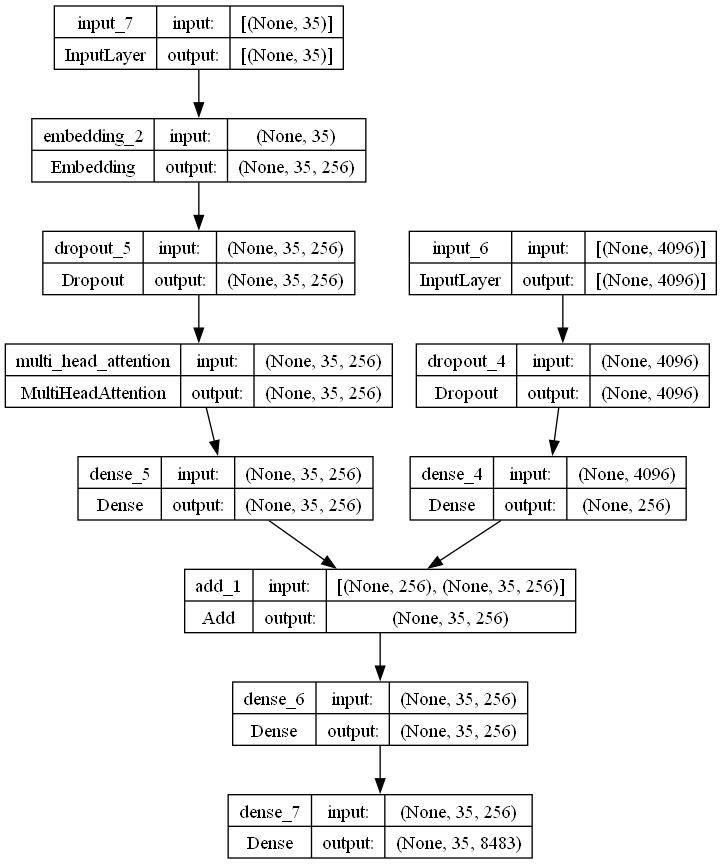

In [41]:
# Vẽ model
plot_model(model, show_shapes=True)

In [29]:
# Train model
epochs = 20 # Càng cao, model càng chính xác
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    print(f"Epoch = {i}")
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

Epoch = 0

113/113 [==============================] - 103s 912ms/step - loss: 4.9207
Epoch = 1

113/113 [==============================] - 100s 887ms/step - loss: 4.0612
Epoch = 2

113/113 [==============================] - 101s 900ms/step - loss: 3.6570
Epoch = 3

113/113 [==============================] - 97s 865ms/step - loss: 3.4084
Epoch = 4

113/113 [==============================] - 95s 847ms/step - loss: 3.2203
Epoch = 5

113/113 [==============================] - 97s 860ms/step - loss: 3.0724
Epoch = 6

113/113 [==============================] - 93s 825ms/step - loss: 2.9577
Epoch = 7

113/113 [==============================] - 102s 907ms/step - loss: 2.8604
Epoch = 8

113/113 [==============================] - 99s 883ms/step - loss: 2.7745
Epoch = 9

113/113 [==============================] - 115s 1s/step - loss: 2.7055
Epoch = 10

113/113 [==============================] - 128s 1s/step - loss: 2.6412
Epoch = 11

113/113 [==============================] - 1098s 10s/step - los

In [30]:
# Lưu model vào thư mục output
model.save(WORKING_DIR + '/model.h5')

### Tạo Caption cho Ảnh

In [31]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [32]:
# Tạo caption cho từng ảnh
def predict_caption(model, image, tokenizer, max_length):
    in_text = '<start>'
    
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Đệm sequence cho đủ length
        sequence = pad_sequences([sequence], max_length)
        # Dự đoán từ tiếp theo
        yhat = model.predict([image, sequence], verbose=0)
        # Lấy index từ có xác suất cao nhất
        yhat = np.argmax(yhat)
        # Chuyển index thành từ
        word = idx_to_word(yhat, tokenizer)
        # Dừng loop nếu không tìm thấy từ
        if word is None:
            break
        # Thêm từ đã tìm được vào chuỗi ban đầu để tiếp tục dự đoán
        in_text += " " + word
        # Dừng loop nếu duyệt đến tag <end>
        if word == '<end>' or word == 'end':
            break
    return in_text

In [33]:
# 2 biến lưu caption thật và dự đoán 
actual, predicted = list(), list()

for key in tqdm(test):
    # Lưu caption thật
    captions = mapping[key]
    # Dự đoán caption
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # Tách thành các từ và add vào list
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

### Kết quả

In [35]:
from PIL import Image

def generate_captions(image_name):
    # Load ảnh
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('-----------------------Actual-----------------------')
    for caption in captions:
        print(caption)
    # Dự đoán caption cho ảnh
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('-----------------------Predicted-----------------------')
    print(y_pred)
    plt.imshow(image)

-----------------------Actual-----------------------
<start> black dog and spotted dog are fighting <end>
<start> black dog and tri-colored dog playing with each other on the road <end>
<start> black dog and white dog with brown spots are staring at each other in the street <end>
<start> two dogs of different breeds looking at each other on the road <end>
<start> two dogs on pavement moving toward each other <end>
-----------------------Predicted-----------------------
<start> two dogs are playing with each other on the beach end end end end end end end end end end end end end end end end end end end end end end end end end


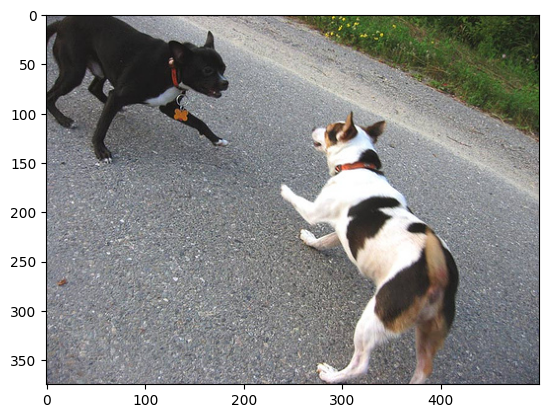

In [36]:
generate_captions("1001773457_577c3a7d70.jpg")

-----------------------Actual-----------------------
<start> black and white dog is running in grassy garden surrounded by white fence <end>
<start> black and white dog is running through the grass <end>
<start> boston terrier is running in the grass <end>
<start> boston terrier is running on lush green grass in front of white fence <end>
<start> dog runs on the green grass near wooden fence <end>
-----------------------Predicted-----------------------
<start> dog runs through the grass end of fence end end end end end end end end end end end end end end end end end end end end end end end end end end end


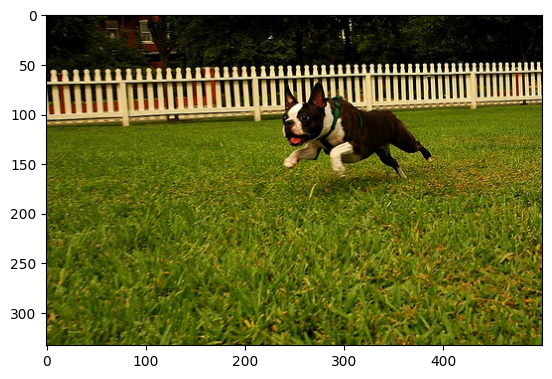

In [37]:
generate_captions("1009434119_febe49276a.jpg")

-----------------------Actual-----------------------
<start> man in blue shirt smoking cigarette <end>
<start> man smokes cigarette <end>
<start> man wearing blue shirt smoking cigarette in front of building <end>
<start> redheaded man smokes cigarette while leaning his head forward <end>
<start> man in blue shirt smoking <end>
-----------------------Predicted-----------------------
<start> man wearing glasses smoking cigarette end his head end end end end end end end end end end end end end end end end end end end end end end end end end end end


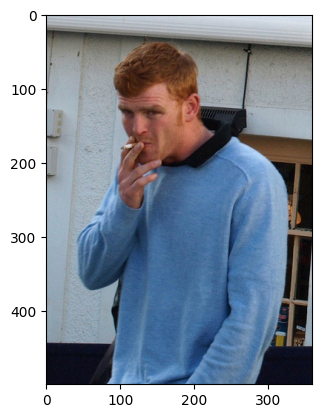

In [38]:
generate_captions("3269380710_9161b0bd00.jpg")